<a href="https://colab.research.google.com/github/Bambani2003/Data_Science_Projects/blob/main/EmotionRecognitionCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Using Convolutional Neural Networks to predict the emotion conveyed in the images.**

In [2]:
# Modules required

import numpy as np
import pandas as pd

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**EDA:**

In [3]:
# Basic format of the dataset

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DataSets/EmotionRecognition.csv')
print(data.shape)
print(data.head)

(35887, 3)
<bound method NDFrame.head of        emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 row

In [4]:
# Cheking the target labels

emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


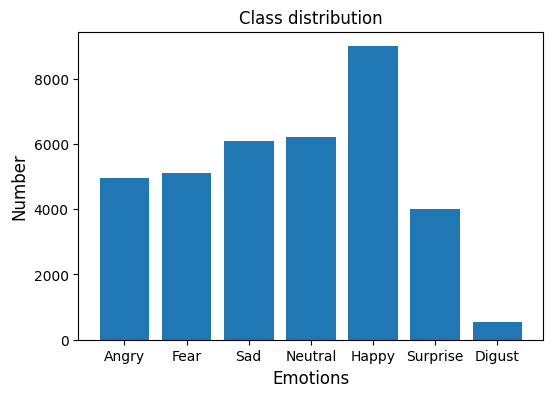

In [5]:
# Plotting a graph of the emotion distributions

plt.figure(figsize=(6,4))
plt.bar(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

There's an almost equal number of images for other emotions except happy and disgust where the number of images are a bit skewed.

<ipython-input-6-34d8fc8a854f>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([image.astype(np.uint8), emotion])


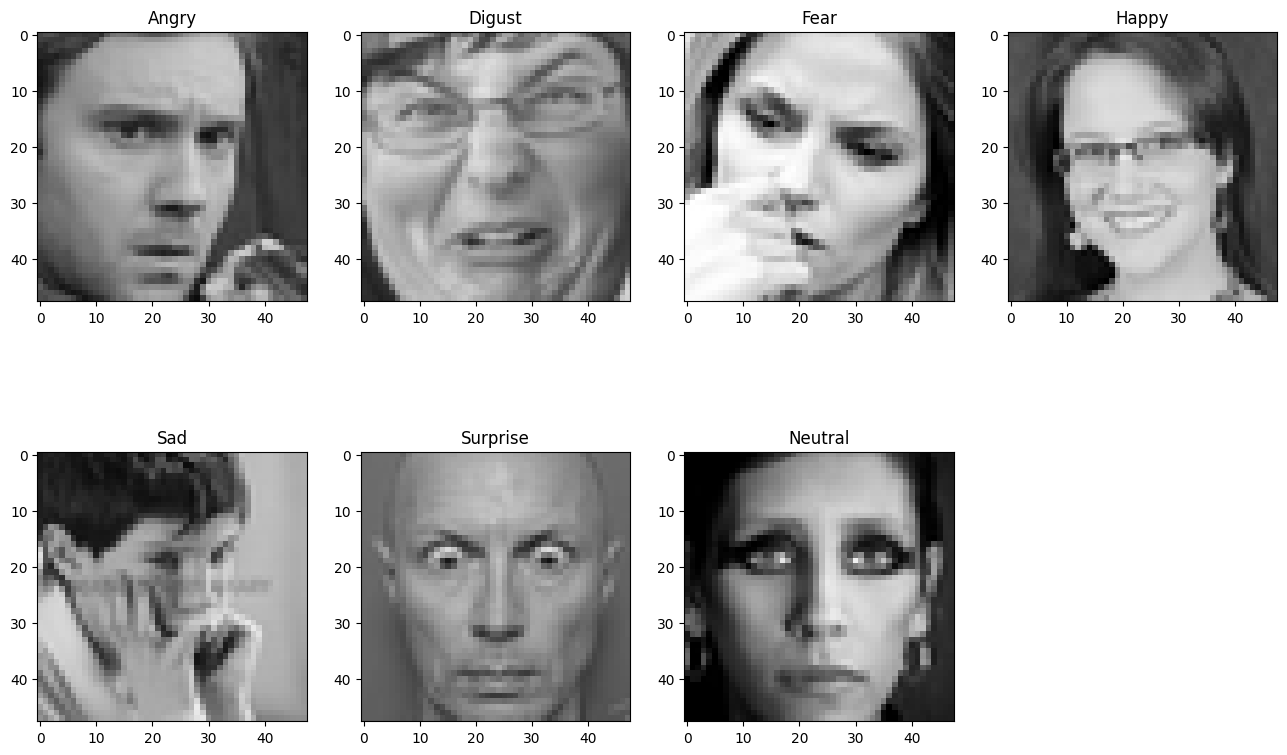

In [6]:
# Sample image of every emotion

def convert_to_image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = convert_to_image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()

**Pre-Processing Data:**

In [7]:
#split data into training, cross validation and test set

data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


In [8]:
# Initilizing parameters

num_classes = 7
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

In [9]:
# Convert strings to lists of integers
# Reshape and Normalise grayscale image with 255.0
# One-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0
    data_Y = to_categorical(df['emotion'], num_classes)
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y


train_X, train_Y = CRNO(data_train, "train")
val_X, val_Y     = CRNO(data_val, "val")
test_X, test_Y   = CRNO(data_test, "test")

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


**Model Building and Machine Learning**
*   We will use the convolutional layer along with batch normalisation and then pool it together.
*   We will then flatten the model and and use the dense layer.

In [13]:
model = Sequential()
input_shape = (48,48,1)
model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(7))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_9 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 128)      

In [14]:
# Data Generator

data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

In [15]:
es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

history = model.fit(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2,
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

Epoch 1/50
448/448 - 36s - loss: 1.7796 - accuracy: 0.2938 - val_loss: 2.0182 - val_accuracy: 0.2650 - 36s/epoch - 80ms/step
Epoch 2/50
448/448 - 18s - loss: 1.5282 - accuracy: 0.4067 - val_loss: 1.5700 - val_accuracy: 0.3876 - 18s/epoch - 40ms/step
Epoch 3/50
448/448 - 19s - loss: 1.3429 - accuracy: 0.4867 - val_loss: 1.4246 - val_accuracy: 0.4374 - 19s/epoch - 42ms/step
Epoch 4/50
448/448 - 18s - loss: 1.2468 - accuracy: 0.5249 - val_loss: 1.3438 - val_accuracy: 0.4968 - 18s/epoch - 41ms/step
Epoch 5/50
448/448 - 21s - loss: 1.1756 - accuracy: 0.5547 - val_loss: 1.2956 - val_accuracy: 0.5183 - 21s/epoch - 47ms/step
Epoch 6/50
448/448 - 21s - loss: 1.1235 - accuracy: 0.5755 - val_loss: 1.1484 - val_accuracy: 0.5578 - 21s/epoch - 46ms/step
Epoch 7/50
448/448 - 20s - loss: 1.0866 - accuracy: 0.5911 - val_loss: 1.0938 - val_accuracy: 0.5837 - 20s/epoch - 45ms/step
Epoch 8/50
448/448 - 19s - loss: 1.0544 - accuracy: 0.6009 - val_loss: 1.0818 - val_accuracy: 0.5837 - 19s/epoch - 42ms/step


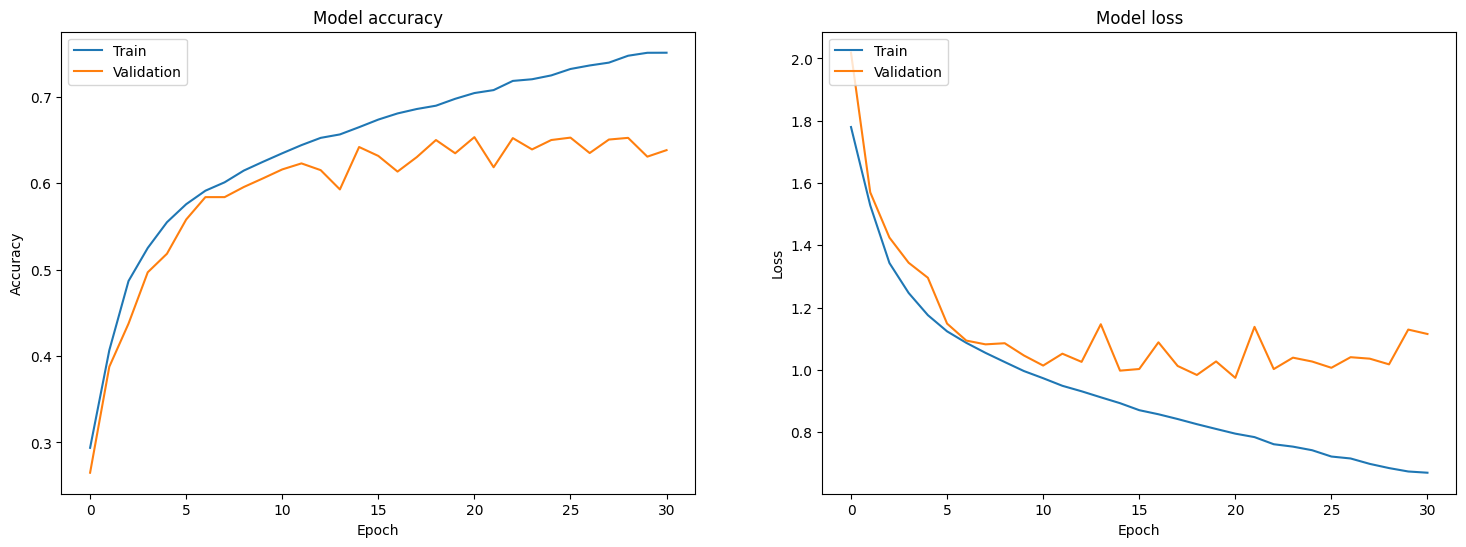

In [16]:
# Visualising and Comparing the accuracy and loss

fig, axes = plt.subplots(1,2, figsize=(18, 6))

axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [17]:
# Test performance

test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}%".format(accuracy_score(test_true, test_pred)*100))

113/113 [==============================] - 1s 6ms/step
CNN Model Accuracy on test set: 66.1744%


Not the best accuracy but considering the benchmark of 65% to 75%, it is a good start.

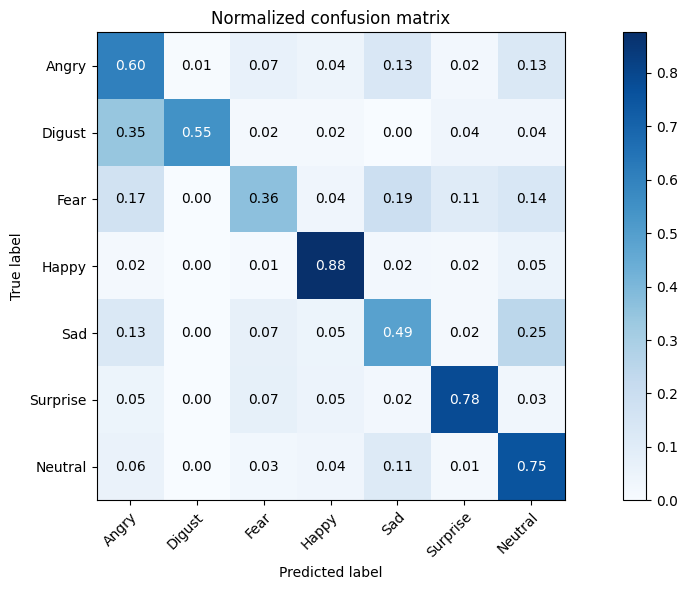

In [20]:
# Confusion matric for classification

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

emotion_labels = ['Angry','Digust','Fear','Happy','Sad','Surprise','Neutral']

plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

**INFERENCE:**

*  Almost all the emotions have high F1 scores except Fear which has a lot of confusion with Disgust.